### **CARTPOLE DQN KERAS**

This is a naive version of the CARTPOLE DQN algorithm <br>
Try to fill the missing parts

This is the simplest approach of DQN with a single network (Remember the standard DQN uses 2 networks and trains one, in this one we use one and train one

Fill the empty places and try to make it to work Ask for help if stocked!!!


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### **Hyperparameters**

In [4]:
# Parameters to fine tune
# Try your own parameters
# Remember epsilon and gamma are very important


MAX_EPISODES = 300
ROLLING_WINDOW = 20
MEMORY_SIZE = 2000
MAX_STEPS = 500

gamma = 0.99                        # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0                             # to see traces (verbosity)

In [5]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### **Neural Network**

In [6]:
###
# [CREATE YOUR NEURAL NETWORK TRY 16/32 or 24/24]
###

def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(16, activation='relu', name="dense_1")(inputs)
    x = Dense(32, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

#### **Support Functions**

$Q_{\text{target}}(s_t, a_t) = r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a') \cdot (1 - \text{done})$

In [8]:
replay_buffer = deque(maxlen=MEMORY_SIZE)

def store(state, action, reward, next_state, done):             
    """
    This function appends the actual observation and reward to the Replay buffer
    """
    state = state.squeeze()
    next_state = next_state.squeeze()
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, model, epsilon):           
    """
    Selects action using epsilon-greedy policy
    """
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = np.reshape(state, [1, state_size])
    act_values = model.predict(state, verbose=verb)
    return np.argmax(act_values[0])

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    """
    Samples a batch_size of experiences from the Replay buffer. 
    You MUST transform the data into numpy arrays as this accelerates the response time sensibily
    """
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    return (states, actions, rewards, next_states, dones)
###
# YOU MUST VECTIORIZE THE RETURN. TRANSFORM THE OUTPUTS IN np arrays otherwise it will be very slow
###

    
def experience_replay(batch_size, model, epsilon):
    """
    The critical function in the whole program
    1. gets a minibatch from replay buffer
    2. Predicts targets_qs from states (we need the full batch predicted but we'll avoid dones)
    3. predicts next_qs from next_states
    4. Bellman equation on next_qs obtains new target_qs $Q_{\text{target}}(s_t, a_t) = r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a') \cdot (1 - \text{done})$

    6. Train DQN input states, output target_qs 

    """
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    
    # Predict Q-values for current and next states using vectorized operations

    
#### 
#  [ Predict target_qs with model predict states, predict next_qs with model predict next states]
####
    target_qs = model.predict(states, verbose=verb) # Get current Q-values for all states
    next_qs = model.predict(next_states, verbose=verb) # Get next Q-values for next states

    # Update target Q-values using standard DQN logic   
    target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
    # Train the model on the Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

###
#[Here you have a load and save weights. Can you make a breakpoint to restart the program after a while of training?]
###

def load(name, DQN):
    DQN.load_weights(name)

def save(name, DQN):
    DQN.save_weights(name)

DQN = build_model(state_size, action_size)
DQN.summary()

Model: "Q_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state_input (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                80        
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Training loop for DQN
rewards_per_episode = []
rolling_avg_rewards = []
rolling_avg = 0

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        action = select_action_greedy(state, DQN, epsilon)  # Updated to pass epsilon
        next_state, reward, done, truncated, _ = env.step(action)
        
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        if len(replay_buffer) > batch_size:
            experience_replay(batch_size, DQN, epsilon)
        
        if done or truncated:
            break
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Track rewards
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)
    
    print(f"Episode: {episode+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3}")
    
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        DQN.save("CartPole_dqn_model.keras")
        break

end_time = time.time()
training_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {training_duration:.2f} minutes")

Episode:   1/300, Reward:  +41.00, Epsilon: 0.99, Rolling Avg:  41.00, Steps:  40
Episode:   2/300, Reward:  +15.00, Epsilon: 0.98, Rolling Avg:  28.00, Steps:  14
Episode:   3/300, Reward:  +33.00, Epsilon: 0.97, Rolling Avg:  29.67, Steps:  32
Episode:   4/300, Reward:  +11.00, Epsilon: 0.96, Rolling Avg:  25.00, Steps:  10
Episode:   5/300, Reward:  +11.00, Epsilon: 0.95, Rolling Avg:  22.20, Steps:  10
Episode:   6/300, Reward:  +55.00, Epsilon: 0.94, Rolling Avg:  27.67, Steps:  54
Episode:   7/300, Reward:  +35.00, Epsilon: 0.93, Rolling Avg:  28.71, Steps:  34
Episode:   8/300, Reward:  +23.00, Epsilon: 0.92, Rolling Avg:  28.00, Steps:  22
Episode:   9/300, Reward:  +14.00, Epsilon: 0.91, Rolling Avg:  26.44, Steps:  13
Episode:  10/300, Reward:  +13.00, Epsilon: 0.90, Rolling Avg:  25.10, Steps:  12
Episode:  11/300, Reward:  +29.00, Epsilon: 0.90, Rolling Avg:  25.45, Steps:  28
Episode:  12/300, Reward:  +12.00, Epsilon: 0.89, Rolling Avg:  24.33, Steps:  11
Episode:  13/300

#### **Learning Plot and Episode Rewards**

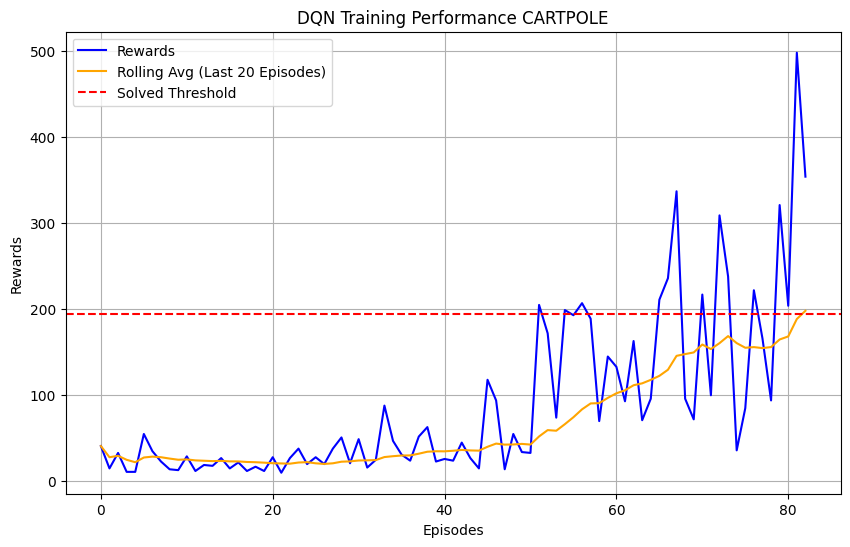

In [10]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [11]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 322.00, Steps: 322
Test Episode:  2/10, Reward: 351.00, Steps: 351
Test Episode:  3/10, Reward: 293.00, Steps: 293
Test Episode:  4/10, Reward: 318.00, Steps: 318
Test Episode:  5/10, Reward: 307.00, Steps: 307
Test Episode:  6/10, Reward: 318.00, Steps: 318
Test Episode:  7/10, Reward: 299.00, Steps: 299
Test Episode:  8/10, Reward: 309.00, Steps: 309
Test Episode:  9/10, Reward: 334.00, Steps: 334
Test Episode: 10/10, Reward: 315.00, Steps: 315
Testing completed in 2.56 minutes


#### **Rendering 1 episode**

In [12]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_DQN.gif')

Rendered Test Episode Reward: 342.00
Saved GIF to: ./CARTPOLE_DQN.gif


## CartPole DDQN

Episode:   1/300, Reward:  +22.00, Epsilon: 0.43, Rolling Avg:  22.00, Steps:  21
Episode:   2/300, Reward:  +66.00, Epsilon: 0.43, Rolling Avg:  44.00, Steps:  65
Episode:   3/300, Reward:  +12.00, Epsilon: 0.42, Rolling Avg:  33.33, Steps:  11
Episode:   4/300, Reward:  +10.00, Epsilon: 0.42, Rolling Avg:  27.50, Steps:   9
Episode:   5/300, Reward:  +17.00, Epsilon: 0.41, Rolling Avg:  25.40, Steps:  16
Episode:   6/300, Reward:  +10.00, Epsilon: 0.41, Rolling Avg:  22.83, Steps:   9
Episode:   7/300, Reward:  +14.00, Epsilon: 0.40, Rolling Avg:  21.57, Steps:  13
Episode:   8/300, Reward:  +12.00, Epsilon: 0.40, Rolling Avg:  20.38, Steps:  11
Episode:   9/300, Reward:   +9.00, Epsilon: 0.40, Rolling Avg:  19.11, Steps:   8
Episode:  10/300, Reward:   +8.00, Epsilon: 0.39, Rolling Avg:  18.00, Steps:   7
Episode:  11/300, Reward:  +15.00, Epsilon: 0.39, Rolling Avg:  17.73, Steps:  14
Episode:  12/300, Reward:  +12.00, Epsilon: 0.38, Rolling Avg:  17.25, Steps:  11
Episode:  13/300

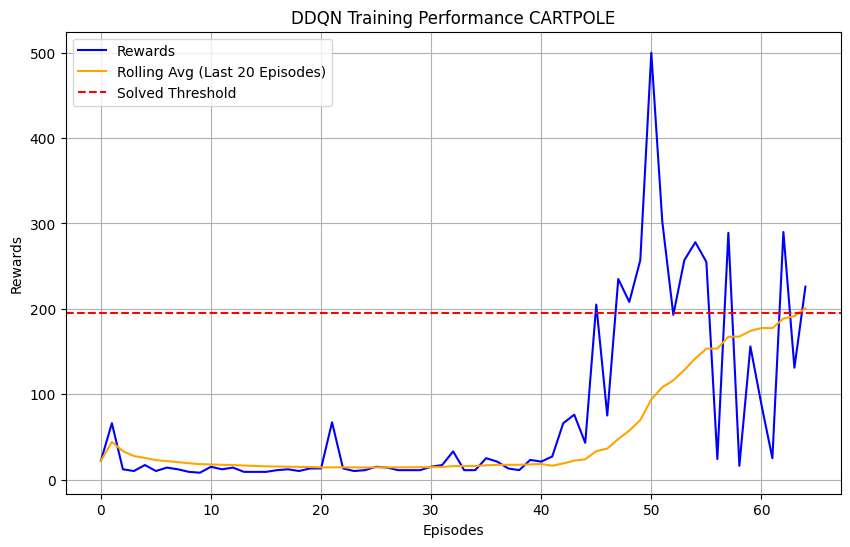

In [13]:
# DDQN Cartpole

def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(24, activation='relu', name="dense_1")(inputs)
    x = Dense(24, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

# Create main and target networks
DQN = build_model(state_size, action_size)
target_DQN = build_model(state_size, action_size)
target_DQN.set_weights(DQN.get_weights()) # Initialize target network with main network weights

def update_target_network():
    """
    Update the target network with the main network weights
    """
    target_DQN.set_weights(DQN.get_weights())

def select_action_greedy(state, model, epsilon):
    """
    Selects action using epsilon-greedy policy
    """
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = np.reshape(state, [1, state_size])
    act_values = model.predict(state, verbose=verb)
    return np.argmax(act_values[0])

def experience_replay(batch_size, model, epsilon):
    """
    Sample a batch of experiences from the replay buffer.
    Double DQN: Use the main network to select the action, and the target network to evaluate the Q-values.
    """
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Get current Q-values from the main network
    target_qs = model.predict(states, verbose=verb)

    # Double DQN: Use the main network to select the action, and the target network to evaluate the Q-values
    next_qs_main = model.predict(next_states, verbose=verb)  # Main network predicts next states
    next_qs_target = target_DQN.predict(next_states, verbose=verb)  # Target network predicts next states

    # Select the best action for each next state using the main network
    best_actions = np.argmax(next_qs_main, axis=1)

    # Get Q-values for the best actions from the target network
    best_qs = next_qs_target[np.arange(batch_size), best_actions]

    # Update the target Q-values using the Bellman equation
    target_qs[np.arange(batch_size), actions] = rewards + gamma * best_qs * (1 - dones)

    # Train the main network on the target Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

# Training loop for DDQN
rewards_per_episode = []
rolling_avg_rewards = []
rolling_avg = 0

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        action = select_action_greedy(state, DQN, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        if len(replay_buffer) > batch_size:
            experience_replay(batch_size, DQN, epsilon)
        
        if done or truncated:
            break
    
    # Update target network every 10 episodes
    if episode % 10 == 0:
        update_target_network()
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Track rewards
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)
    
    print(f"Episode: {episode+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3}")
    
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        DQN.save("CartPole_ddqn_model.keras")
        break

end_time = time.time()
training_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {training_duration:.2f} minutes")

# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()